In [19]:
import cv2
from PIL import Image, ImageDraw
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
import random
import tensorflow as tf

In [86]:
dir_examples = 'proj1/examples/'
directory = 'proj1/images/'
def get_images_in_dir(directory='./'):
    files = os.listdir(directory)
    images = [directory+f for f in files]
    return images
fnames = get_images_in_dir(directory)

In [87]:
fig_size = [8,8]
plt.rcParams["figure.figsize"] = fig_size

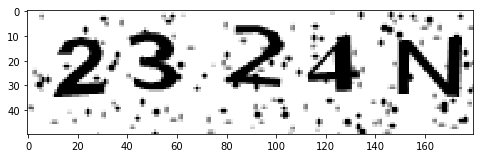

In [89]:
# img = Image.open("captcha.bmp")
img = cv2.imread(fnames[0])
plt.imshow(img)

In [6]:
def delete_noise(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)    
    median = cv2.medianBlur(thresh,3)
    img = cv2.cvtColor(median,cv2.COLOR_GRAY2BGR)
    kernel = np.ones((2,2),np.uint8)
    img = cv2.erode(img,kernel,iterations = 1)
    img = cv2.dilate(img,kernel,iterations = 1)
    return img

In [7]:
def count_white_pixels(img):
#     charcpy = np.empty_like(img)
#     np.copyto(charcpy,img)
    height, width, ch = img.shape
    # count total white pixels (required for clustering)
    colwise_wlist = []
    totalwhite = 0
    
    for col in range(width):
        wctr = 0
        bctr = 0
        for row in range(height):
            if np.array_equal(img[row][col] , np.array([255,255,255])):
                wctr += 1
                totalwhite += 1
        colwise_wlist.append(wctr)
    return colwise_wlist, totalwhite

In [8]:
def get_white_pixels(img, totalwhite):
    height, width, ch = img.shape
    a = np.zeros(shape=(totalwhite,2), dtype=np.uint32)
    ctr = 0
    for row in range(height):
        for col in range(width):
            if np.array_equal(img[row][col] , np.array([255,255,255])):
                a[ctr] = np.array([row,col])
                ctr += 1
    return a

In [9]:
def apply_K_means(img, a):
    z = np.float32(a)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    K = 5 # clusters count
    compactness,labels,centers = cv2.kmeans(z,K,None,criteria,10,flags)
    return compactness,labels,centers

In [10]:
def cluster(img):
    img = delete_noise(img)
    charcpy = np.empty_like(img)
    np.copyto(charcpy,img)
    
    _, totalwhite = count_white_pixels(img)
    a = get_white_pixels(img, totalwhite)
    compactness,labels,centers = apply_K_means(img, a)
    
    height, width, ch = img.shape
    charHeight, charWidth = height,35
    char_imgs = []
    centers = sorted(centers,key=lambda x: x[1])
    for c in range(len(centers)):
        Crow,Ccol = centers[c][0],int(centers[c][1])
        x1 = (Ccol-int(charWidth/2)) if ((Ccol-int(charWidth/2)) > 0) else 0
        x2 = (Ccol+int(charWidth/2)) if ((Ccol+int(charWidth/2)) < width) else width
        char_imgs.append(charcpy[0:height , x1:x2])
    return char_imgs

In [11]:
def highlight_chars(img):
    img = delete_noise(img)
    _, totalwhite = count_white_pixels(img)
    a = get_white_pixels(img, totalwhite)
    compactness,labels,centers = apply_K_means(img, a)
    
    height, width, ch = img.shape
    # define colors to be used
    colors = [np.array([255,0,0]),np.array([0,255,0]),np.array([0,0,255]),np.array([255,255,0]),np.array([255,0,255])]
    imcpy = np.empty_like(img)
    np.copyto(imcpy,img)
    # draw colors according to cluster labels
    for i in range(len(a)):
        row,col = a[i][0],a[i][1]
        thisColor = colors[labels[i][0]]
        imcpy[row][col] = thisColor

    for c in range(len(centers)):
        Crow,Ccol = centers[c][0],int(centers[c][1])
        for row in range(height):
            imcpy[row][Ccol] = np.array([255,255,255])
    return imcpy

In [12]:
def print_5_images(imgs):
    for i in range(1,len(imgs)+1):
        plt.subplot(1,5,i)
        plt.imshow(imgs[i-1])
    plt.show()

In [83]:
imgs = cluster(img)

error: ..\..\..\modules\imgproc\src\color.cpp:7456: error: (-215) scn == 3 || scn == 4 in function cv::ipp_cvtColor


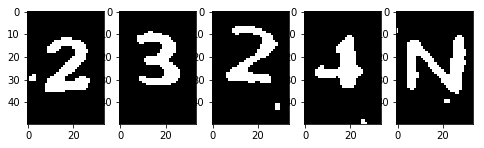

In [14]:
print_5_images(imgs)

In [16]:
rand_name = lambda l, n: l+''.join([random.choice(string.ascii_letters + string.digits) for n in range(n)])
namesize = 5

In [17]:
fnames[0]

'proj1/images/2324N.bmp'

In [75]:
# for file in fnames[:1]:
#     img = cv2.imread(file)
#     ch_imgs = cluster(img)
#     char_names = list(file.split('.')[0].split('/')[-1])
#     for im, name in zip(ch_imgs, char_names):
#         dname = dir_examples+name+'/'
# #         if not os.path.exists(dname):
# #             os.makedirs(dname)
#         fname = dname+rand_name(name, namesize)+'.bmp'
# #         while os.path.exists(fname):
# #             fname = dir_examples+rand_name(name, namesize)+'.bmp'
#         cv2.imwrite(fname,im)

In [20]:
imgs[4].shape

(50, 34, 3)

In [21]:
h, w = 50, 34

In [22]:
sz = w * h
sz

1700

In [23]:
labels = os.listdir(dir_examples)

In [28]:
data = {key:[] for key in labels}

In [29]:
# for k in list(data.keys()):
#     dir_name = dir_examples+k
#     files = [dir_name+'/'+f for f in os.listdir(dir_examples+k)]
#     for f in files:
#         img = cv2.imread(f)
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#         _, img = cv2.threshold(img,0,1,cv2.THRESH_BINARY)
#         if img.shape[1] < 34:
#             img = np.append(img,np.zeros((1,50)))
#             while img.shape[0] < sz:
#                 img = np.append(img,np.zeros((1,50)))
#         img = img.reshape(1,w*h)
#         data[k].append(img)

In [77]:
pickle_file = 'data2.dat'

In [31]:
# with open(pickle_file, 'wb') as f:
#     pickle.dump(data, f)

In [32]:
with open(pickle_file, "rb") as f:
        training_data = pickle.load(f)

In [33]:
chars = list(training_data.keys())
chars.sort()

In [34]:
labels = {}
i = 0
for c in chars:
    labels[c] = i
    i += 1
labels_count = i

In [35]:
inputData_x = []
inputData_y = []
for c in training_data:
    for i in range(len(training_data[c])):
        inputData_x.append(training_data[c][i][0])
        label_temp = [0]*labels_count
        label_temp[labels[c]] = 1
        inputData_y.append(label_temp)

In [36]:
inputData_x = np.array(inputData_x)
inputData_y = np.array(inputData_y)
print("total : ",len(inputData_x),len(inputData_y))

total :  7455 7455


In [38]:
# shuffle the data
inputData = list(zip(inputData_x,inputData_y))
random.shuffle(inputData)
inputData_x,inputData_y = zip(*inputData)

In [39]:
# separate training and testing data
separateRatio = 0.20
testing_data_len = int(len(inputData_x) * separateRatio)
trainingData_x = inputData_x[:len(inputData_x)-testing_data_len]
trainingData_y = inputData_y[:len(inputData_y)-testing_data_len]

testingData_x = np.array(inputData_x[len(inputData_x)-testing_data_len:])
testingData_y = np.array(inputData_y[len(inputData_y)-testing_data_len:])

print("training : ",len(trainingData_x),len(trainingData_y))
print("testing  : ",len(testingData_x),len(testingData_y))

training :  5964 5964
testing  :  1491 1491


In [188]:
# model
# hidden_layer_sz = 500
x = tf.placeholder(tf.float32, [None,sz])

# W1 = tf.Variable(tf.truncated_normal((sz,hidden_layer_sz), stddev=0.1))
# b1 = tf.Variable(tf.zeros([hidden_layer_sz]))
# W2 = tf.Variable(tf.truncated_normal((hidden_layer_sz,labels_count), stddev=0.1))
# b2 = tf.Variable(tf.zeros([labels_count]))

# hidden = tf.nn.relu(tf.matmul(x, W1) + b1)
# hidden_do = tf.nn.dropout(hidden, 0.8)
# y = tf.nn.relu(tf.matmul(hidden_do, W2) + b2)

W = tf.Variable(tf.truncated_normal((sz,labels_count), stddev=0.01))
# W = tf.nn.dropout(W, 0.5)
# W = tf.Variable(tf.zeros([sz,labels_count]))
b = tf.Variable(tf.zeros([labels_count]))
# b = tf.Variable(tf.constant(0.1, shape=[labels_count]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

y_right = tf.placeholder(tf.float32, [None, labels_count])
cost = tf.reduce_mean(-tf.reduce_sum(y_right * tf.log(y), reduction_indices=[1]))
# cost = tf.reduce_mean(tf.reduce_sum(tf.square(y - y_right)))

# training
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
# train_step = tf.train.AdamOptimizer(0.5).minimize(cost)
# train_step = tf.train.RMSPropOptimizer(0.5).minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
# testing
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_right,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [189]:
EPOCHS = 10000

In [190]:
sess = tf.Session()
if True:
    sess.run(init)
    for i in range(EPOCHS):
        tr_data = list(zip(trainingData_x,trainingData_y))
        random.shuffle(tr_data)
        trainingData_x,trainingData_y = zip(*tr_data)
        
        batch_indices = random.sample(range(0, len(trainingData_x)),100)
        batch_x = []
        batch_y = []
        for r in batch_indices:
            batch_x.append(trainingData_x[r])
            batch_y.append(trainingData_y[r])
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        sess.run(train_step, feed_dict={x: batch_x, y_right: batch_y})
        if i % 1000 == 0:
            print('Epoch: ', i)
            print("Accuracy :",sess.run(accuracy, feed_dict={x: testingData_x, y_right: testingData_y}))
    print('Learned')
    print("Accuracy :",sess.run(accuracy, feed_dict={x: testingData_x, y_right: testingData_y}))

Epoch:  0
Accuracy : 0.144199
Epoch:  1000
Accuracy : 0.692824
Epoch:  2000
Accuracy : 0.704896
Epoch:  3000
Accuracy : 0.707579
Epoch:  4000
Accuracy : 0.713615
Epoch:  5000
Accuracy : 0.711603
Epoch:  6000
Accuracy : 0.70825
Epoch:  7000
Accuracy : 0.711603
Epoch:  8000
Accuracy : 0.712944
Epoch:  9000
Accuracy : 0.711603
Learned
Accuracy : 0.712274


In [94]:
def model(x_in,Wts,bs):
    yop = tf.nn.softmax(tf.matmul(x_in, Wts) + b)
    return yop

In [194]:
k = 0
test_x = np.asarray([testingData_x[k]] ,dtype=np.float32)
predict_op = model(test_x,W,b)
op = sess.run(predict_op, feed_dict={x: test_x})
mmax = op[0][0]
maxi = -1
maxi = op.argmax()
# for i in range(labels_count):
#     if op[0][i] > mmax:
#         mmax = op[0][i]
#         maxi = i
print(chars[maxi], chars[testingData_y[k].argmax()])

J 2


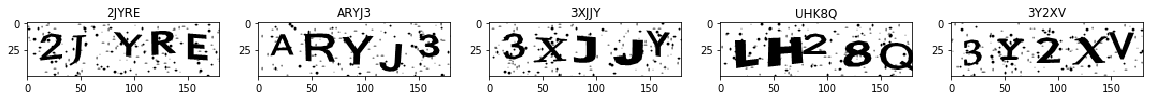

In [192]:
fig_size = [20,20]
plt.rcParams["figure.figsize"] = fig_size
kks = [30, 420, 100, 900, 101]
ind = 1
for kk in kks:
    ti = cv2.imread(fnames[kk])
    tis = cluster(ti)
    right_answer = list(fnames[kk].split('.')[0].split('/')[-1])
    ress = []
    predict_op = tf.nn.softmax(tf.matmul(x, W) + b)
    for ii in tis:
        i = cv2.cvtColor(ii,cv2.COLOR_BGR2GRAY)
        _, i = cv2.threshold(i,0,1,cv2.THRESH_BINARY)
        if i.shape[1] < 34:
            i = np.append(i,np.zeros((1,50)))
            while i.shape[0] < sz:
                i = np.append(i,np.zeros((1,50)))
        i = i.reshape(1,w*h)
    
        r = sess.run(predict_op, feed_dict={x: i})
#         print(r.argmax())
        ress.append(chars[r.argmax()])

    plt.subplot(1,5,ind)
    plt.title(''.join(ress))
    plt.imshow(ti)
    ind += 1
#     print(ress)
plt.show()

In [193]:
saver_name = 'proj1/net2.model'
saver.save(sess, saver_name)

'proj1/net2.model'

In [187]:
sess.close()

In [ ]:
saver.restore(sess, saver_name)